In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
print(tf.__version__)

1.1.0


In [2]:
class RNN:
    def __init__(self, session, batch_size, n_steps, n_inputs, n_state_units, n_classes):
        self.session = session
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_state_units = n_state_units
        self.n_classes = n_classes
        
    def make_rnn(self):
        self.x = tf.placeholder(tf.float32, [None, self.n_steps, self.n_inputs])
        self.xt = tf.transpose(self.x, perm = [1, 0, 2])
        self.xr = tf.reshape(self.xt, shape = [-1, self.n_inputs])
        self.xs = tf.split(value=self.xr, num_or_size_splits=self.n_steps, axis=0)
        self.y = tf.placeholder(tf.float32, [None, n_classes])
                
        self.rnn_cell = tf.contrib.rnn.BasicLSTMCell(num_units = n_state_units)
        self.outputs, self.final_state = tf.contrib.rnn.static_rnn(self.rnn_cell, 
                                                                   self.xs, 
                                                                   dtype=tf.float32)
        
        self.W2 = tf.Variable(tf.random_normal([self.n_state_units, self.n_classes]))
        self.B = tf.Variable(tf.random_normal([self.n_classes]))

        self.pred = tf.matmul(self.outputs[-1], self.W2) + self.B
    
    def restoreModel(self, path='./rnn_sine_model.ckpt'):
        tf.train.Saver().restore(sess=self.session, save_path=path)
        print("Model restored successfully.")
            
    def get_final_test_pred(self, data_x):
        pred = self.session.run(self.pred, feed_dict={
            self.x: data_x 
        })
        return pred

In [3]:
def split_data(data, val_size=0.1, test_size=0.2):
    """
    splits data to training, validation and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))
    nval = int(round(len(data) * (1 - (val_size + test_size))))

    train_data, val_data, test_data = data[:nval], data[nval:ntest], data[ntest:]
    return train_data, val_data, test_data

def prepare_data(data, n_steps):
    x = []
    y = []
    for i in range(len(data) - n_steps - 1):
        x_item = []
        for j in range(n_steps):
            x_item.append([data[i + j]])
        x.append(x_item)
        y.append([data[i + n_steps]])
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y    

def generate_data(func, x, n_steps):
    """
    generates data with based on a function fct
    creates new data frame based on previous observation
       * example:
        l = [1, 2, 3, 4, 5]
        n_steps = 3
        -> [[[1], [2], [3]], [[2], [3], [4]], [[3], [4], [5]]]
    """
    data = func(x)
    train_data, val_data, test_data = split_data(data, val_size=0.1, test_size=0.2)
    train = {}
    val = {}
    test = {}
    train['x'], train['y'] = prepare_data(train_data, n_steps)
    val['x'], val['y'] = prepare_data(val_data, n_steps)
    test['x'], test['y'] = prepare_data(test_data, n_steps)
    return train, val, test

INFO:tensorflow:Restoring parameters from ./rnn_sine_model.ckpt
Model restored successfully.


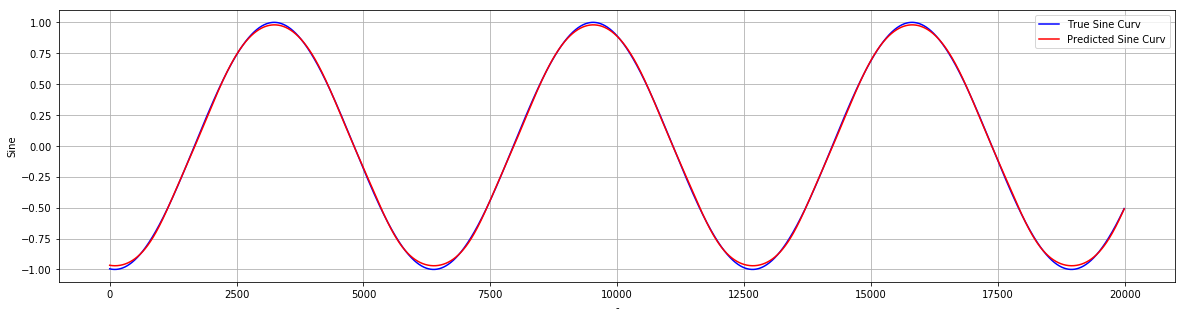

In [4]:
batch_size = 128
n_steps = 10
n_inputs = 1
n_state_units = 4
n_classes = 1
learning_rate = 0.01
max_training_epochs = 10

if __name__ == '__main__':
    with tf.Session() as session:   
        rnn = RNN(session, batch_size, n_steps, n_inputs, n_state_units, n_classes)
        rnn.make_rnn()
        rnn.restoreModel()

        _, _, test = generate_data(np.sin, np.linspace(0, 100, 100000), n_steps)
        pred = rnn.get_final_test_pred(test['x'])
        fig = plt.figure(figsize=(20, 5))
        plt.subplot(111)
        plt.plot(range(0, len(test['x'])), test['y'], 'b', label='True Sine Curv')
        plt.plot(range(0, len(test['x'])), pred, 'r', label='Predicted Sine Curv')
        plt.ylabel('Sine')
        plt.xlabel('-')
        plt.grid(True)
        plt.legend(loc='upper right')